Integrantes: Felipe Martínez y Benjamin Zamorano\
https://github.com/Thefelixctm/Talleres-VDD-Felipe-Martinez-y-Benjamin-Zamorano

# Práctico de Geolocalización y Visualización de Datos

In [ ]:
pip install geopandas folium

In [ ]:
# Bibliotecas a ocupar
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import folium
from shapely.geometry import Point
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker
import branca.colormap as cm

## 1. **Carga y preprocesamiento de datos**  


Para este programa ocuparemos el set de Datos del COVID:

In [ ]:
## Importar los datos en un DataFrame de pandas.

formato_fecha = '%Y-%m-%d'
df = pd.read_csv('coronavirus_2020.csv', dtype={'province': str})

# Crear una copia del dataframe para no modificar el original
dfCopia = df.copy()

In [ ]:
# Procesar las fechas
tempfechas = []
for i in df['date']:
    tempfechas.append(datetime.strptime(i, formato_fecha))

dfCopia['date'] = tempfechas

In [ ]:
## Inspeccionar sus columnas.
df.head()

,date,province,country,lat,long,type,cases,uid,iso2,iso3,code3,combined_key,population,continent_name,continent_code
0,2020-01-22,Alberta,Canada,53.9333,-116.5765,confirmed,0,12401.0,CA,CAN,124.0,"Alberta, Canada",4413146.0,North America,NaN
1,2020-01-23,Alberta,Canada,53.9333,-116.5765,confirmed,0,12401.0,CA,CAN,124.0,"Alberta, Canada",4413146.0,North America,NaN
2,2020-01-24,Alberta,Canada,53.9333,-116.5765,confirmed,0,12401.0,CA,CAN,124.0,"Alberta, Canada",4413146.0,North America,NaN
3,2020-01-25,Alberta,Canada,53.9333,-116.5765,confirmed,0,12401.0,CA,CAN,124.0,"Alberta, Canada",4413146.0,North America,NaN
4,2020-01-26,Alberta,Canada,53.9333,-116.5765,confirmed,0,12401.0,CA,CAN,124.0,"Alberta, Canada",4413146.0,North America,NaN


In [ ]:
## Inspeccionar tipos de datos.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293940 entries, 0 to 293939
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date            293940 non-null  object 
 1   province        88665 non-null   object 
 2   country         293940 non-null  object 
 3   lat             292215 non-null  float64
 4   long            292215 non-null  float64
 5   type            293940 non-null  object 
 6   cases           293940 non-null  int64  
 7   uid             282900 non-null  float64
 8   iso2            278760 non-null  object 
 9   iso3            279795 non-null  object 
 10  code3           279795 non-null  float64
 11  combined_key    282900 non-null  object 
 12  population      277380 non-null  float64
 13  continent_name  279795 non-null  object 
 14  continent_code  229770 non-null  object 
dtypes: float64(5), int64(1), object(9)
memory usage: 33.6+ MB


In [ ]:
## Manejar valores faltantes o atípicos que puedan afectar la geolocalización.
# Convertir columnas lat y long a numérico, manejando errores
dfCopia['lat'] = pd.to_numeric(dfCopia['lat'], errors='coerce')
dfCopia['long'] = pd.to_numeric(dfCopia['long'], errors='coerce')

# Contar valores faltantes
missing_lat = dfCopia['lat'].isna().sum()
missing_long = dfCopia['long'].isna().sum()

# Verificar valores atípicos fuera del rango válido para coordenadas geográficas
outliers_lat = dfCopia[(dfCopia['lat'] < -90) | (dfCopia['lat'] > 90)]
outliers_long = dfCopia[(dfCopia['long'] < -180) | (dfCopia['long'] > 180)]

print("Valores faltantes(lat)=", missing_lat, "\nValores faltantes(long)=", missing_long,"\nValores Atipicos(lat)=", len(outliers_lat),"\nValores Atipicos(long)=", len(outliers_long))


Valores faltantes(lat)= 1725 
Valores faltantes(long)= 1725 
Valores Atipicos(lat)= 0 
Valores Atipicos(long)= 0


In [ ]:
# Eliminar registros con latitud o longitud faltante en dfCopia
dfCopia = dfCopia.dropna(subset=['lat', 'long'])

# Confirmar que no hay valores faltantes en lat/long después del filtrado
clean_lat_na = dfCopia['lat'].isna().sum()
clean_long_na = dfCopia['long'].isna().sum()

print("Valores faltantes (lat) =", clean_lat_na,
      "\nValores faltantes (long) =", clean_long_na)


Valores faltantes (lat) = 0 
Valores faltantes (long) = 0


In [ ]:
#Verificar que se hayan eliminado las filas sin lat y long
dfCopia.info()

<class 'pandas.core.frame.DataFrame'>
Index: 292215 entries, 0 to 293939
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            292215 non-null  datetime64[ns]
 1   province        86940 non-null   object        
 2   country         292215 non-null  object        
 3   lat             292215 non-null  float64       
 4   long            292215 non-null  float64       
 5   type            292215 non-null  object        
 6   cases           292215 non-null  int64         
 7   uid             281865 non-null  float64       
 8   iso2            277725 non-null  object        
 9   iso3            278760 non-null  object        
 10  code3           278760 non-null  float64       
 11  combined_key    281865 non-null  object        
 12  population      277380 non-null  float64       
 13  continent_name  278760 non-null  object        
 14  continent_code  228735 non-null  object  

## 2. **Análisis exploratorio**  


In [ ]:
## Calcula estadísticas descriptivas de las variables clave (conteos, medias, distribuciones).
## Crea al menos dos gráficos estáticos (histograma, scatter plot, boxplot) que resuman el dataset.
# Establecimos que los datos importantes para analizar son la cantidad de casos (cases) y la población (population)
Casos=dfCopia.cases
Poblacion=dfCopia.population

In [ ]:
print("Conteo=",Casos.count())
print("Promedio=",Casos.mean())

Conteo= 292215
Promedio= 454.2095101209726


In [ ]:
df_positive = df[df['cases'] > 0]

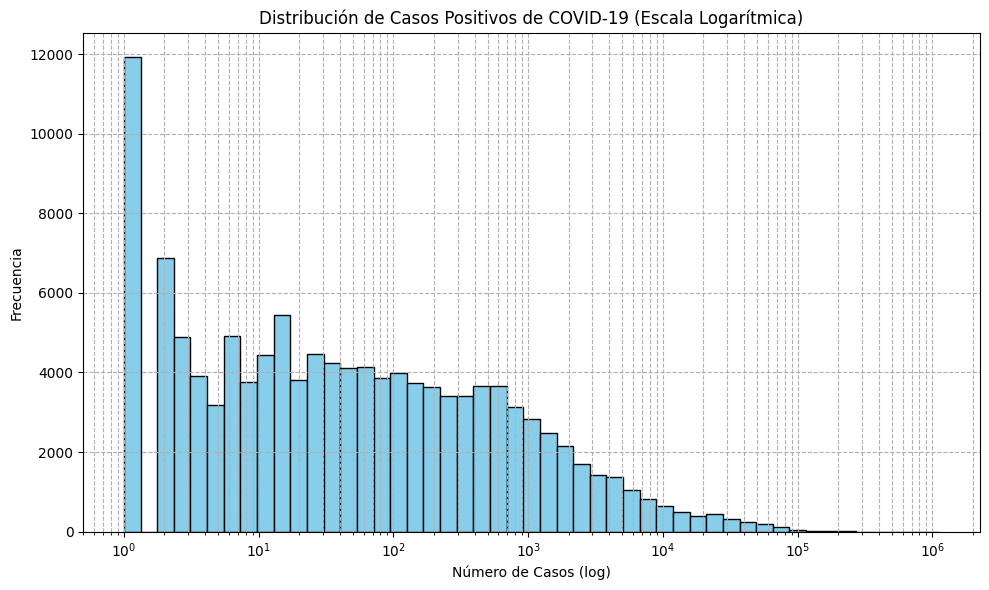

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_positive['cases'], bins=np.logspace(np.log10(1), np.log10(df_positive['cases'].max()), 50),
         color='skyblue', edgecolor='black')

plt.xscale('log')
plt.title('Distribución de Casos Positivos de COVID-19 (Escala Logarítmica)')
plt.xlabel('Número de Casos (log)')
plt.ylabel('Frecuencia')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

In [ ]:
# Agrupamos por provincia y sumamos los casos
casos_por_provincia = df.groupby('province')['cases'].sum().sort_values(ascending=False)

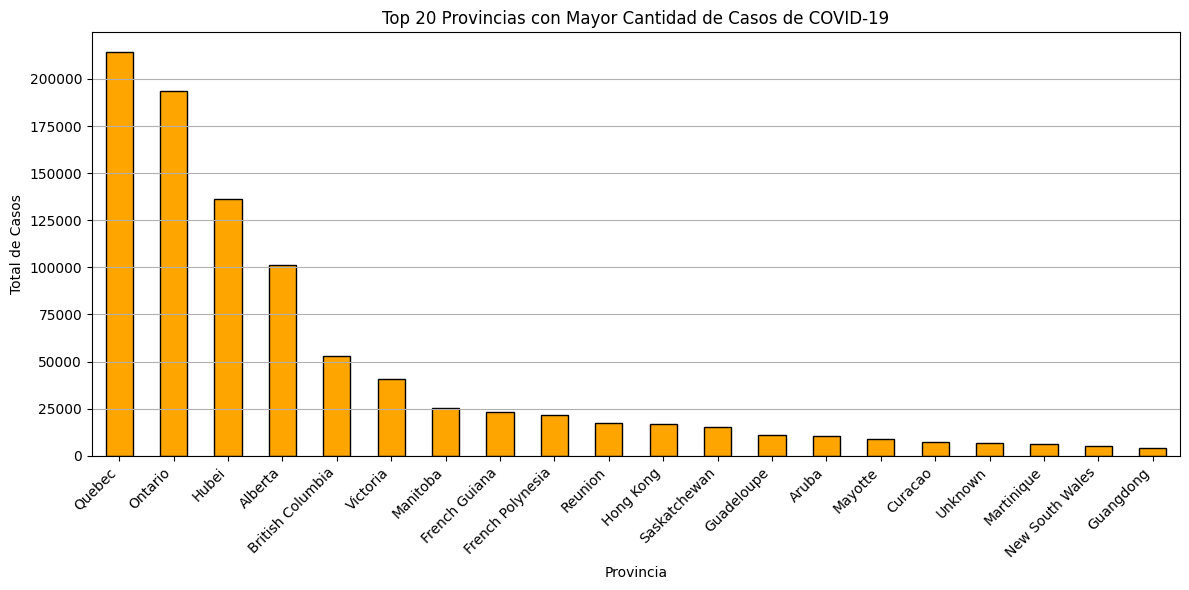

In [ ]:
# Seleccionamos las 20 provincias con más casos
top_provincias = casos_por_provincia.head(20)

plt.figure(figsize=(12, 6))
top_provincias.plot(kind='bar', color='orange', edgecolor='black')

plt.title('Top 20 Provincias con Mayor Cantidad de Casos de COVID-19')
plt.xlabel('Provincia')
plt.ylabel('Total de Casos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [ ]:
# Agrupamos por continente y sumamos los casos
casos_por_continente = df.groupby('continent_name')['cases'].sum().sort_values(ascending=False)


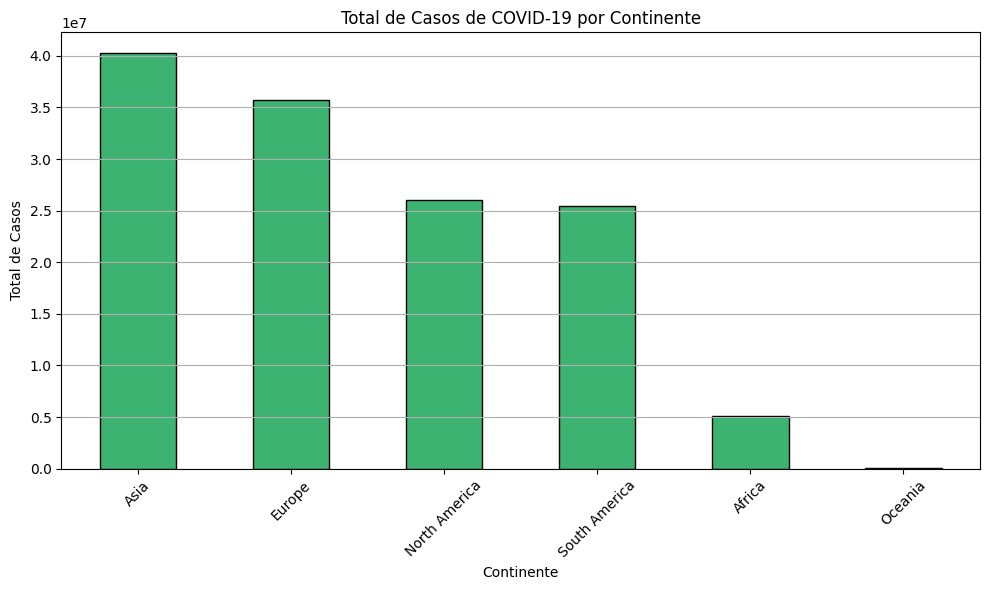

In [ ]:
plt.figure(figsize=(10, 6))
casos_por_continente.plot(kind='bar', color='mediumseagreen', edgecolor='black')

plt.title('Total de Casos de COVID-19 por Continente')
plt.xlabel('Continente')
plt.ylabel('Total de Casos')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

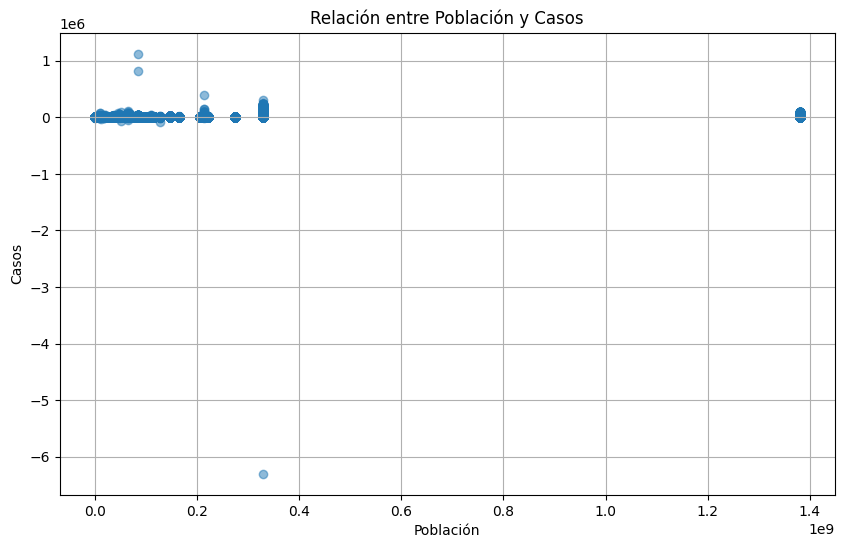

In [ ]:
# Generar un scatter plot entre población y casos
plt.figure(figsize=(10, 6))
plt.scatter(dfCopia['population'], dfCopia['cases'], alpha=0.5)
plt.title('Relación entre Población y Casos')
plt.xlabel('Población')
plt.ylabel('Casos')
plt.grid(True)
plt.show()

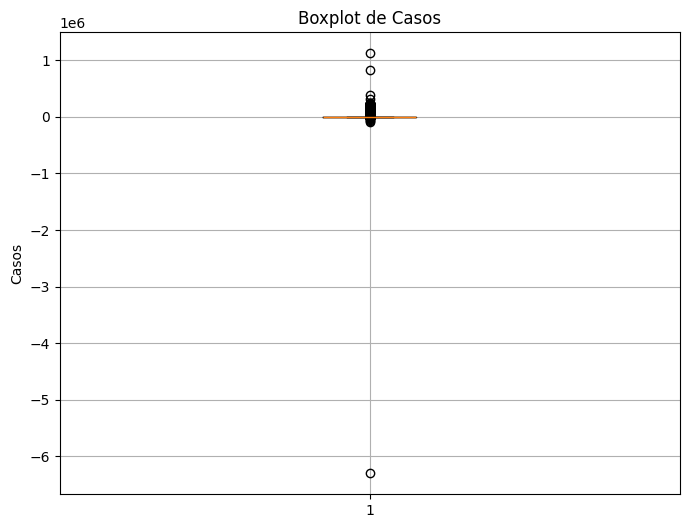

In [ ]:
# Boxplot para los Casos
plt.figure(figsize=(8, 6))
plt.boxplot(Casos, vert=True)
plt.title('Boxplot de Casos')
plt.ylabel('Casos')
plt.grid(True)
plt.show()

## 3. **Geocodificación**

En este caso el csv ya cuenta con las variables latitud (lat) y longitud (long), variables que ya fueron verificadas anteriormente (solo eliminando las filas con datos faltantes, ya que no se presento ningun problema de rango).

## 4. **Mapa estático con GeoPandas**  

In [ ]:
## Carga un shapefile o utiliza un dataset geográfico con `geopandas` para obtener el contorno de la región de estudio.
## Sobrepón tus puntos en un mapa estático, diferenciándolos por alguna variable (color, tamaño).

In [ ]:
# Agrupar por coordenadas y calcular promedio
df_coord_avg = dfCopia.groupby(["lat", "long"])["cases"].mean().reset_index()
df_coord_avg.columns = ["Lat", "Lon", "Promedio_Casos"]

In [ ]:
#Crear GeoDataFrame
geometry = [Point(xy) for xy in zip(df_coord_avg["Lon"], df_coord_avg["Lat"])]
gdf_avg = gpd.GeoDataFrame(df_coord_avg, geometry=geometry, crs="EPSG:4326")

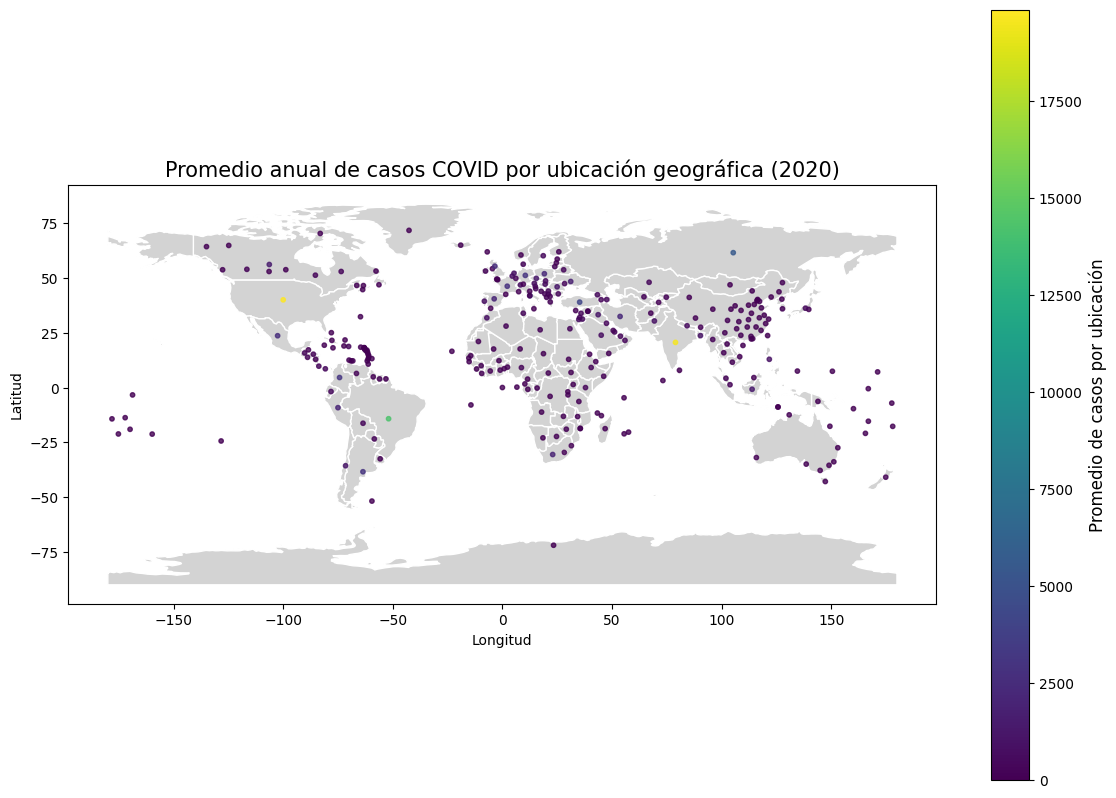

In [ ]:
#Para esta parte es necesario importa el archivo ".shp" ".shx" ".dbf" del archivo "ne_110m_admin_0_countries.zip".
# Cargar shapefile del mundo
world = gpd.read_file("ne_110m_admin_0_countries.shp")

# Normalizar escala
norm = Normalize(vmin=0, vmax=gdf_avg["Promedio_Casos"].max())

# Graficar
fig, ax = plt.subplots(figsize=(14, 10))
world.plot(ax=ax, color="lightgray", edgecolor="white")

gdf_avg.plot(
    ax=ax,
    column="Promedio_Casos",
    cmap="viridis",
    markersize=10,
    alpha=0.8,
    legend=False,
    norm=norm
)

# Colorbar personalizada
sm = ScalarMappable(cmap="viridis", norm=norm)
sm._A = []
cbar = plt.colorbar(sm, ax=ax)
cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
cbar.ax.ticklabel_format(style='plain')
cbar.set_label("Promedio de casos por ubicación", fontsize=12)

# Estética
ax.set_title("Promedio anual de casos COVID por ubicación geográfica (2020)", fontsize=15)
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
plt.show()


## 5. **Mapa interactivo con Folium**  

In [ ]:
## Crea un mapa interactivo centrado en el área de interés.
## Añade marcadores o círculos con pop-ups que muestren información clave al hacer clic.

#En este caso no hay un area de interes como tal, debido a que la información va por pais, decidimos mostrar todo.
# Usar última fecha
dfCopia['date'] = pd.to_datetime(dfCopia['date'])
latest_date = df['date'].max()
df = df[df['date'] == latest_date]

# Agrupar por ubicación
grouped = df.groupby('combined_key').agg({
    'cases': 'sum',
    'lat': 'mean',
    'long': 'mean'
}).reset_index()

# Crear mapa
mapa = folium.Map(location=[grouped['lat'].mean(), grouped['long'].mean()],
                  zoom_start=2,
                  tiles='CartoDB positron')

# Escala de color
colormap = cm.LinearColormap(
    colors=['#440154', '#3e4989', '#26828e', '#35b779', '#fde725'],
    vmin=grouped['cases'].min(),
    vmax=grouped['cases'].max(),
    caption='Casos Confirmados'
)

# Añadir puntos
for _, row in grouped.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius=max(2, np.log1p(row['cases'])),
        color=colormap(row['cases']),
        fill=True,
        fill_opacity=0.7,
        popup=f"{row['combined_key']}: {row['cases']} casos"
    ).add_to(mapa)

mapa

## 6. **Preguntas de reflexión**  

- **¿Qué patrones espaciales observas?**\
Los patrones que destacan son la Aglomeración en Europa y Centroamerica; Hotspots en Estados Unidos, Brasil e India.


- **¿Hay concentraciones o “clusters” de datos en zonas específicas?**\
Se puede ver una alta Aglomeración en el continente Europeo y en Centro America, esto debido a que tienen un alto nivel de paises.

- **¿Qué limitaciones encontraste al geocodificar y mapear estos datos?**    
Se encontraron valores faltantes en las columnas de Latitud y Longitud en la Base de Datos, lo cual nos presentaba problemas a la hora de Geocodificar.